In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
from Data.KS.KS_order import KS


In [3]:
torch.cuda.empty_cache()


exp_dir   = "G:/PhD_Imperial/PhD_Projects/MZA_Cluster_Models/KS/Exp6.4.2.2_L22_KS_testlargedata_nodropout_nhutest"

models = []

exp_name_list = [
                 "sl49_nhu64_numobs8_bs512_lr5e-5_ph20_2",\
                 "sl49_nhu100_numobs8_bs512_lr5e-5_ph20_2",\
                 "sl49_nhu128_numobs8_bs512_lr5e-5_ph20_2",\
                 "sl49_nhu200_numobs8_bs512_lr5e-5_ph20_2"
                #  "sl65_nhu40_numobs8_bs512_lr5e-5_ph20_2",\
                #  "sl129_nhu40_numobs8_bs512_lr5e-5_ph20_2"
                ]


for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

lt = 93.024

sl49_nhu64_numobs8_bs512_lr5e-5_ph20_2
sl49_nhu100_numobs8_bs512_lr5e-5_ph20_2
sl49_nhu128_numobs8_bs512_lr5e-5_ph20_2
sl49_nhu200_numobs8_bs512_lr5e-5_ph20_2


In [4]:
print("Deactivate Model: ", models[0].deactivate_seqmodel)

Deactivate Model:  False


In [5]:
print("Pred horizon: ", models[0].pred_horizon)

Pred horizon:  20


Epoch with Minimum train_error:  5336


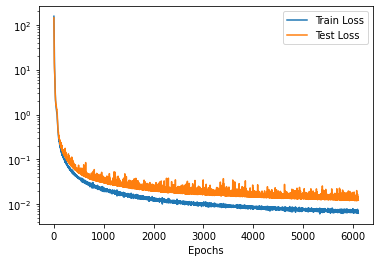

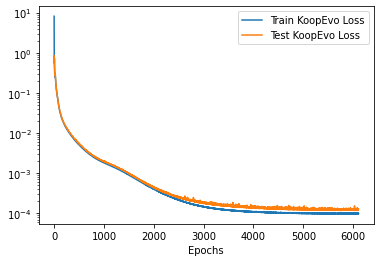

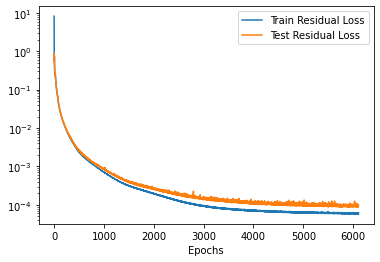

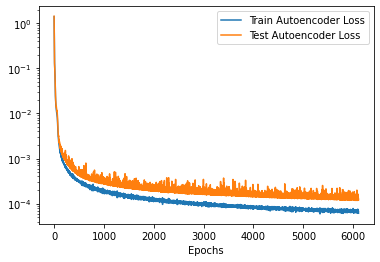

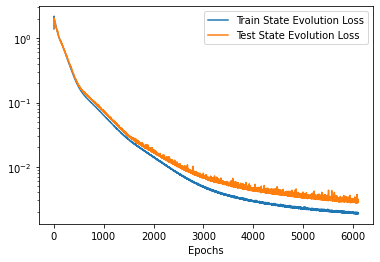

In [8]:
#plot learning curves
models[1].plot_learning_curves()

In [9]:
#for autoencoder_seq loading the strcuture separately for clarity and security
# for i in range(0,len(models)):
#     models[i].model.autoencoder = Autoencoder_seq(input_size = models[i].statedim, latent_size = models[i].num_obs, linear_ae = models[i].linear_autoencoder).to(models[0].device)

for i in range(0,len(models)):
    epoch_num = 7999
    models[i].load_weights(epoch_num, True)

In [10]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1

In [11]:

#One Step Prediction
model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Test")
dataset = models[model_num].test_dataset
num_trajs = models[model_num].test_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0


Data Shape:  (1, 75000, 512)
Not normalizing Input
Test_Shape:  (1, 7500, 512)


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([1, 7499, 8]) torch.Size([1, 7499, 512]) torch.Size([1, 7499, 512])


In [12]:
Phi = models[0].test_data

Text(0, 0.5, 'MSE')

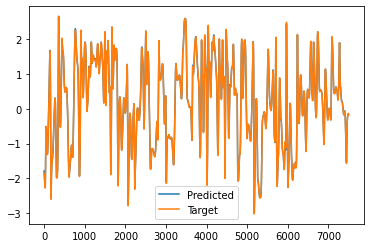

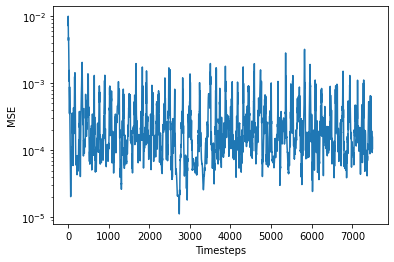

In [13]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "Target")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

Multi Step

In [86]:
for i in range(len(models)):
    models[i].deactivate_seqmodel = False

In [27]:
#multistep prediction
timesteps = 4000
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 512])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([4, 1, 4001, 512]) torch.Size([4, 1, 4000, 512])


ValueError: x and y must have same first dimension, but have shapes (4000,) and (201,)

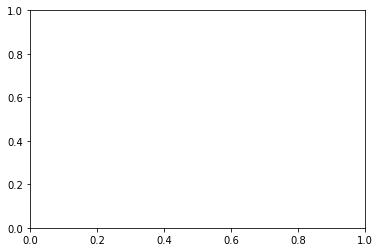

In [47]:
#kinetic energy of multistep rpediciton
def KS_kinetic_energy(Phi):
    L = 22
    k = 0.5*np.mean(Phi**2, axis = -1)/L
    return k

plt.figure()

timesteps_ke = 4000
lt = 93.024
x = np.arange(timesteps_ke)/lt

for i in [0]:
    
    plt.plot(x, KS_kinetic_energy(Phi_ms_hat[i,0,0:timesteps_ke].detach().cpu().numpy()), label = f"nhu {models[i].num_hidden_units}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(x[:], KS_kinetic_energy(Phi[0,initial_step:timesteps_ke+initial_step]), label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Lyapunov Times")
plt.ylabel("kinetic energy")

Text(0, 0.5, 'Probability Density')

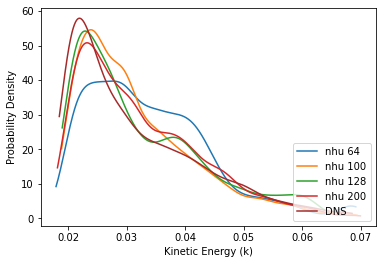

In [30]:
#pdf of kinteic energy

plt.figure()

for i in [0,1,2,3]:
    k, pdf = Eval_MZA.calc_pdf(KS_kinetic_energy(Phi_ms_hat[i,0,:].detach().cpu().numpy()))
    plt.plot(k,pdf , label = f"nhu {models[i].num_hidden_units}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
k, pdf = Eval_MZA.calc_pdf(KS_kinetic_energy(Phi[0,initial_step:timesteps+initial_step]))
plt.plot(k, pdf, label = "DNS",color = "brown")

plt.legend(loc='lower right')

plt.xlabel('Kinetic Energy (k)')
plt.ylabel('Probability Density')



[  0.           0.28559933   0.57119866   0.856798     1.14239733
   1.42799666   1.71359599   1.99919533   2.28479466   2.57039399
   2.85599332   3.14159265   3.42719199   3.71279132   3.99839065
   4.28398998   4.56958931   4.85518865   5.14078798   5.42638731
   5.71198664   5.99758598   6.28318531   6.56878464   6.85438397
   7.1399833    7.42558264   7.71118197   7.9967813    8.28238063
   8.56797996   8.8535793    9.13917863   9.42477796   9.71037729
   9.99597663  10.28157596  10.56717529  10.85277462  11.13837395
  11.42397329  11.70957262  11.99517195  12.28077128  12.56637061
  12.85196995  13.13756928  13.42316861  13.70876794  13.99436728
  14.27996661  14.56556594  14.85116527  15.1367646   15.42236394
  15.70796327  15.9935626   16.27916193  16.56476126  16.8503606
  17.13595993  17.42155926  17.70715859  17.99275793  18.27835726
  18.56395659  18.84955592  19.13515525  19.42075459  19.70635392
  19.99195325  20.27755258  20.56315191  20.84875125  21.13435058
  21.419949

Text(0, 0.5, 'kinetic energy')

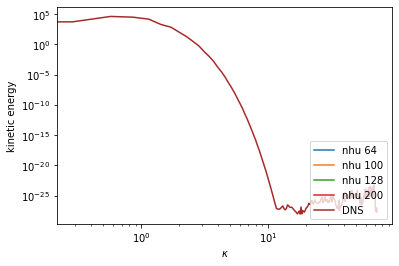

In [46]:
#energy spectrum
dt = 0.025
N  = 512
num_trajs = 1
max_n = int(8000/dt)
L = 22/(2*np.pi)#1/np.sqrt(0.085)
kse = KS(dt=dt, N=N, lambda2=1, L = L)

plt.figure()

timesteps_ke = 4000
lt = 93.024
x = np.arange(1000)/lt

Phi_ms_hat_fft = np.fft.rfft(Phi_ms_hat.detach().cpu().numpy())
k_fft = 0.5*np.mean(np.abs(Phi_ms_hat_fft)**2, axis = -2)
print(k_fft[0,0].shape)
for i in [0,1,2,3]:
    
    plt.loglog(kse.k[:-1], k_fft[i,0,:-1], label = f"nhu {models[i].num_hidden_units}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
Phi_fft = np.fft.rfft(Phi[0,initial_step:timesteps+initial_step], axis = -1)
print(Phi_fft.shape)
k_fft = 0.5*np.mean(np.abs(Phi_fft)**2, axis = 0)
plt.loglog(kse.k[:-1], k_fft[:-1], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel(r"$\kappa$")
plt.ylabel("kinetic energy")



Text(0, 0.5, '$\\mathcal{K}(x_{2})$')

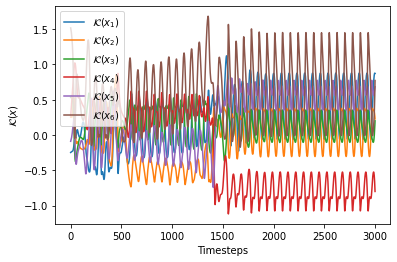

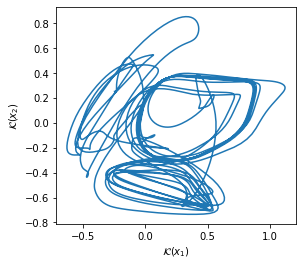

In [18]:
#plotting koopman mode evolution
plt.figure()
model_num = 2
for n in [0,1,2,3,4,5]:#range(models[model_num].num_obs):
    plt.plot(xkoop_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\mathcal{K}$"+f"$(x_{n+1})$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\mathcal{K}(x)$")


plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:,1].cpu().numpy())

plt.xlabel(r"$\mathcal{K}(x_{1})$")
plt.ylabel(r"$\mathcal{K}(x_{2})$")

Text(0, 0.5, 'Observables $  L_{2} Norm$')

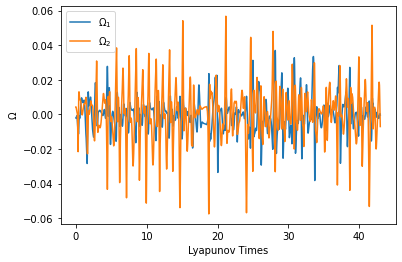

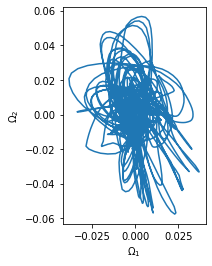

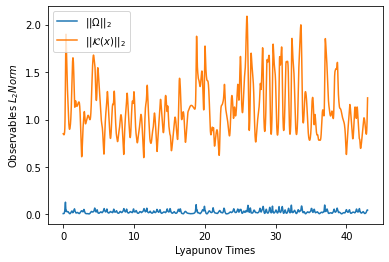

In [32]:
#plotting seqmodel mode evolution
plt.figure()
lt = 93.024
x = np.arange(timesteps)/lt

model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(x, xseq_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Lyapunov Times")
plt.ylabel(r"$\Omega$")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:,0].cpu().numpy(), xseq_ms_hat[model_num][0,:,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure()
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)


# plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
# plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.plot(x, (tgt_xseq_norm)[0,:], label = r"$||\Omega||_{2}$")
plt.plot(x, (tgt_xkoop_norm)[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.legend()
plt.xlabel("Lyapunov Times")
plt.ylabel("Observables " + r"$  L_{2} Norm$")

torch.Size([1, 7499, 512]) torch.Size([4, 1, 4001, 512])


Text(0, 0.5, 'MSE')

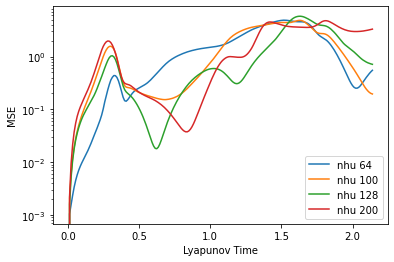

In [37]:
print(Phi_nn.shape, Phi_ms_hat.shape)
timesteps_mse = 200
State_MSE_multistep = torch.zeros((len(models),timesteps_mse))

x = np.arange(timesteps_mse)/lt
plt.figure()
for i in [0,1,2,3]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps_mse],Phi_ms_hat[i,:,:timesteps_mse]).detach().cpu()
    # if i!=len(models)-1:
    
    plt.semilogy(x, State_MSE_multistep[i].numpy(), label = f"nhu {models[i].num_hidden_units}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Lyapunov Time")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [ ]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,1,2,3,4,5,6,7]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Number of Hidden Units {models[i].seq_len}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

Jacobian Analysis

In [42]:
#multistep prediction
timesteps_jac = 200
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps_jac+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps_jac,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

grad_xn_xseq = []

for i in [0,1,2,3,4,5]:#range(len(models)):
    
    grad_xn_xseq.append(models[i].jacobian_calc(initial_conditions, timesteps_jac))
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)

print(grad_xn_xseq[0].shape)

ic shape: torch.Size([1, 512])
0 torch.Size([1, 48])
1 torch.Size([1, 48])
2 torch.Size([1, 48])
3 torch.Size([1, 48])


IndexError: list index out of range

torch.Size([200])
3 torch.Size([1, 48])
2 torch.Size([1, 48])
1 torch.Size([1, 48])
0 torch.Size([1, 48])


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2668\479225273.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])


Text(0.5, 0, 'Timesteps')

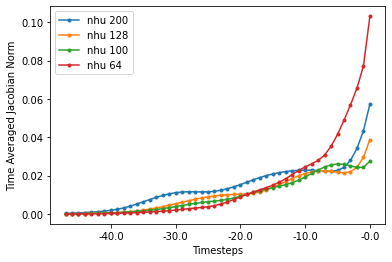

In [51]:
x = torch.arange(timesteps_jac)/lt
print(x[:].shape)
plt.figure()
for i in [3,2,1,0]:#range(len(models)):
    
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)
    inv_n = torch.flip(n,[1])
    inv_x = torch.flip(x,[0])
    plt.plot( inv_n[0,:], ".-", label = f"nhu {models[i].num_hidden_units}")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])
plt.ylabel("Time Averaged Jacobian Norm")
plt.xlabel("Timesteps")

Eigenvalue Study

[0.9995781 +0.00122807j 0.9995781 -0.00122807j 0.9989042 +0.j
 0.99777097+0.00438485j 0.99777097-0.00438485j 0.99362403+0.00055972j
 0.99362403-0.00055972j 0.98835003+0.j        ]


Text(0, 0.5, '$Img(\\lambda)$')

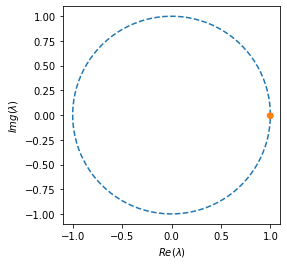

In [30]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", markersize = 9, label = f"Num Observables {models[i].num_obs}")

plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Img(\lambda)$")
# plt.legend()

array([ 0.00210516+0.j        , -0.00347392+0.00109473j,
       -0.00347392-0.00109473j, -0.00875963+0.00837195j,
       -0.00875963-0.00837195j, -0.02677284+0.02029551j,
       -0.02677284-0.02029551j, -0.02844698+0.j        ], dtype=complex64)

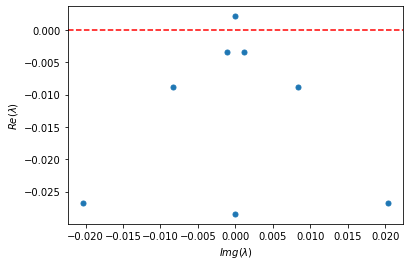

In [31]:
plt.figure()

plt.axhline(0, color='red', linestyle='--')

# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.25)
    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", markersize = 10, label = f"Num Observables {models[i].num_obs}")

plt.ylabel(r"$Re(\lambda)$")
plt.xlabel(r"$Img(\lambda)$")

# plt.ylim(-0.1,0.1)
# plt.xlim(-1,1)
# plt.legend()
lamb

[[ 9.9496859e-01 -2.7642509e-03  3.0011777e-04 -1.6891175e-03
  -2.7540221e-04 -1.3716707e-03 -8.7370383e-05 -3.5600855e-03]
 [ 3.5239980e-03  9.9896210e-01 -3.9317813e-03  2.3971545e-05
  -3.9840741e-03 -1.1288672e-03  2.2717242e-03 -1.2203357e-03]
 [-4.4026179e-03 -2.1587136e-04  9.9744809e-01  7.6194736e-04
  -5.1080598e-05  1.1914276e-03 -3.5016041e-03  1.2245193e-03]
 [-2.5827095e-03 -1.4118454e-03  3.7031353e-03  9.9696785e-01
  -5.3299894e-03 -1.6309510e-03  3.4757892e-03 -2.9120769e-03]
 [-1.4375855e-04 -1.8070314e-04  1.1852700e-03 -1.1757481e-03
   9.9085438e-01 -4.0748171e-03  1.9252177e-03 -3.6987637e-03]
 [ 5.0554718e-03 -2.5932284e-04  1.0310042e-04 -1.5694434e-03
   3.9921734e-03  9.9609774e-01 -2.3096814e-03 -3.1228226e-03]
 [-2.2831997e-03  1.7803500e-03  1.0990807e-03  3.3782932e-03
  -1.9229562e-03  2.3593550e-04  9.9716038e-01  1.4796383e-03]
 [-3.4158181e-03 -2.0727464e-03 -4.7668237e-03 -5.9483427e-04
  -2.9022668e-03 -7.6899666e-04 -1.2843939e-03  9.9674135e-01]]

<Figure size 432x288 with 0 Axes>

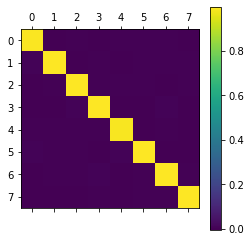

In [35]:
#Matrix
plt.figure()


for i in [1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    plt.matshow(mat)
    plt.colorbar()
    # plt.figure()
    # plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")
    print(mat)
# plt.legend()